# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections

### This notebook examines the health inspection violation data. We propose two simple models for benchmarking purposes. We do not work with the Yelp data in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
df = pd.read_csv('training_labels.txt')
df.head()

,id,date,restaurant_id,*,**,***
0,589,2010-02-02,KAoKWjog,3,0,1
1,28589,2009-12-10,p038M4om,2,0,0
2,31170,2008-07-16,B1oXymOV,4,0,0
3,2600,2015-01-30,m0oWJl3G,1,0,3
4,1016,2012-03-19,rJoQwlEV,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27088 entries, 0 to 27087
Data columns (total 6 columns):
id               27088 non-null int64
date             27088 non-null object
restaurant_id    27088 non-null object
*                27088 non-null int64
**               27088 non-null int64
***              27088 non-null int64
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


In [4]:
df.describe().applymap(lambda x: round(x, 4))

,id,*,**,***
count,27088.0000,27088.0000,27088.0000,27088.0000
mean,16897.4581,4.0474,0.3524,0.9158
std,9785.8206,4.1605,0.6318,1.4871
min,0.0000,0.0000,0.0000,0.0000
25%,8399.5000,1.0000,0.0000,0.0000
50%,16872.5000,3.0000,0.0000,0.0000
75%,25364.2500,6.0000,1.0000,1.0000
max,33859.0000,49.0000,7.0000,17.0000


### Zero model

Our first model is to simply predict the median number of violations across all inspections. This would be 3, 0, 0 for 1-star, 2-star, 3-star as seen in the 6th row in the table above. While this completely ignores the Yelp data it gives us a well-understood benchmark which we will surely beat.

In [5]:
sb = pd.read_csv('SubmissionFormat.csv')
sb['*'] = 3
sb.to_csv('zero_model.csv', index=False, header=True)
sb.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,3,0,0
1,29767,2013-12-30,WwOaAnOB,3,0,0
2,29338,2011-04-08,we39kvOk,3,0,0
3,7219,2013-12-30,dj3d5Xo9,3,0,0
4,20979,2008-03-31,XJ3rBW3R,3,0,0


### Convert date to NumPy data type

In [6]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27088 entries, 0 to 27087
Data columns (total 6 columns):
id               27088 non-null int64
date             27088 non-null datetime64[ns]
restaurant_id    27088 non-null object
*                27088 non-null int64
**               27088 non-null int64
***              27088 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.2+ MB


### Check for unique values

Let's look at the number of unique values per column:

In [8]:
df['id'].unique().size

27088

In [9]:
df['restaurant_id'].unique().size

1851

In [10]:
np.unique(df['date'].values).size

2077

In [11]:
df['date'].unique().size

2077

We see that the id's are unique while the restaurant_id's suggest multiple inspections.

### Which days of the week are the inspections carried out on and how many per year?

(-0.5, 6.5)

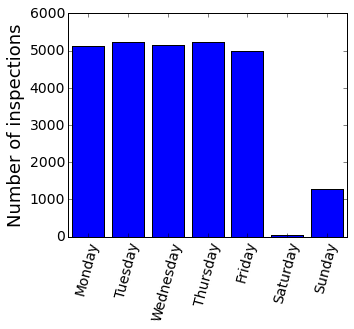

In [12]:
counts, _ = np.histogram(df['date'].apply(lambda x: x.dayofweek), bins=7, range=(0, 7))
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.bar(range(7), counts, align='center')
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), labels, rotation=75)
plt.ylabel('Number of inspections')
plt.xlim(-0.5, 6.5)

(-0.5, 9.5)

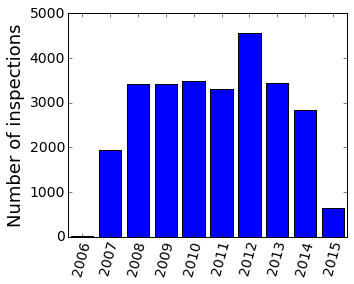

In [13]:
counts, _ = np.histogram(df['date'].apply(lambda x: x.year), bins=10, range=(2006, 2016))
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.bar(range(10), counts, align='center')
labels = range(2006, 2017)
plt.xticks(range(10), labels, rotation=75)
plt.ylabel('Number of inspections')
plt.xlim(-0.5, 9.5)

Data for 2015 is not complete.

### Plot the violation data

Visualize the violations by date and level:

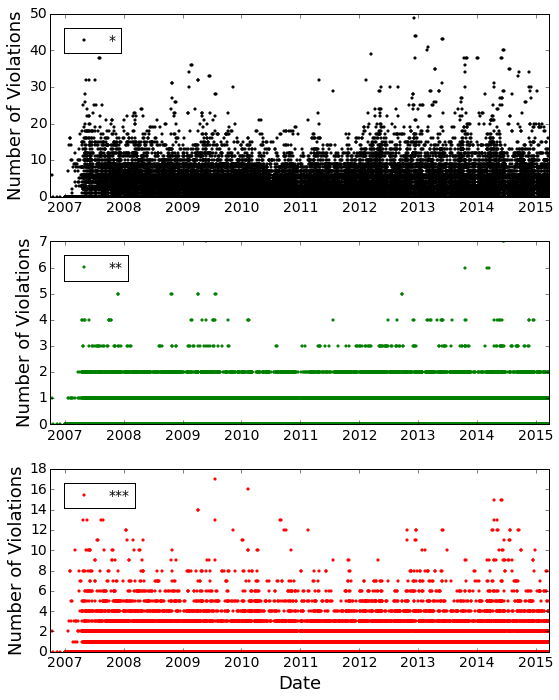

In [14]:
clr = ['k', 'g', 'r']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
for i, stars in enumerate(['*', '**', '***']):
    ax[i].plot(df.date, df[stars], '.', color=clr[i], label=stars, ms=5)
    if (i == 2): ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Number of Violations')
    ax[i].legend(loc='upper left')
plt.tight_layout()

The number of violations of each type is approximately uniform over time. There are many more one-star violations than the other two.

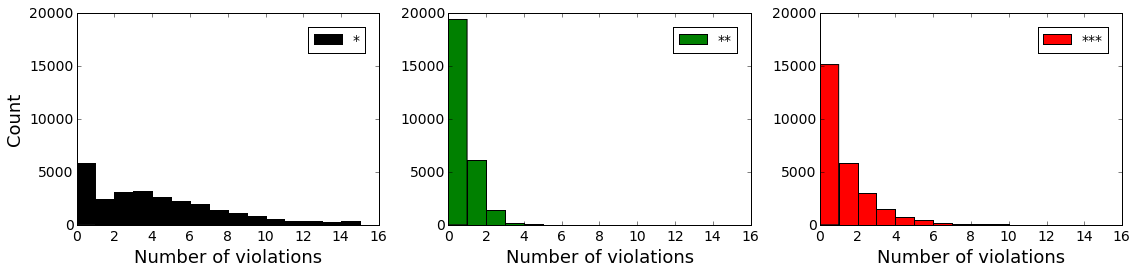

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i, stars in enumerate(['*', '**', '***']):
    ax[i].hist(df[stars], label=stars, color=clr[i], bins=15, width=1, range=(0, 15))
    ax[i].set_xlabel('Number of violations')
    if (i == 0): ax[i].set_ylabel('Count')
    ax[i].legend(loc='upper right')
    ax[i].set_ylim(0, 20000)
plt.tight_layout()

### How many times were each of the 1851 restaurants inspected?

In [16]:
num_inspect = pd.crosstab(index=df["restaurant_id"], columns="count")
num_inspect.columns = ["Number of inspections"]
num_inspect.sort_values('Number of inspections', ascending=False, inplace=True)
num_inspect.head(10)

,Number of inspections
restaurant_id,
1JEbamOR,45
wmo7bb3q,42
KAoKz83g,42
Y1EmLmOw,42
Pk3w4wod,40
dj3dX539,40
0ZEDGWOD,40
ZBEnaqOY,39
6K3lb8Oz,37


In [17]:
most_rated = df.groupby('restaurant_id').size().sort_values(ascending=False)[:10]
most_rated

restaurant_id
1JEbamOR    45
Y1EmLmOw    42
KAoKz83g    42
wmo7bb3q    42
dj3dX539    40
Pk3w4wod    40
0ZEDGWOD    40
ZBEnaqOY    39
6K3lb8Oz    37
NbE1bk3J    37
dtype: int64

In [18]:
df.restaurant_id.value_counts()[:10]

1JEbamOR    45
Y1EmLmOw    42
wmo7bb3q    42
KAoKz83g    42
dj3dX539    40
Pk3w4wod    40
0ZEDGWOD    40
ZBEnaqOY    39
6K3lb8Oz    37
NbE1bk3J    37
Name: restaurant_id, dtype: int64

In [19]:
num_inspect.describe()

,Number of inspections
count,1851.000000
mean,14.634252
std,7.876801
min,1.000000
25%,9.000000
50%,14.000000
75%,20.000000
max,45.000000


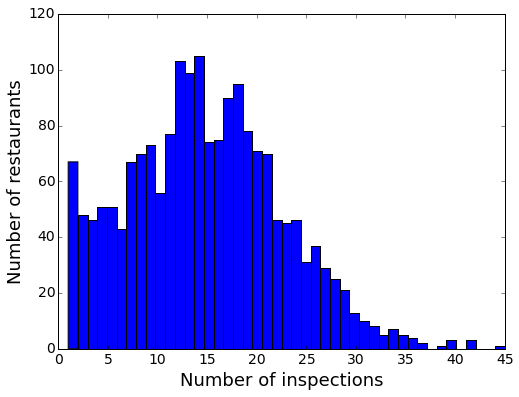

In [20]:
plt.hist(num_inspect['Number of inspections'], bins=45)
plt.xlabel('Number of inspections')
plt.ylabel('Number of restaurants')

Let's look at the violations of the restaurant with the most inspections:

In [21]:
most_inspections = df[df.restaurant_id == num_inspect.index[0]]
most_inspections.sort_values('date')

,id,date,restaurant_id,*,**,***
19747,14966,2007-02-12,1JEbamOR,10,1,5
24714,18738,2007-02-13,1JEbamOR,10,1,5
22753,11966,2007-02-22,1JEbamOR,8,1,1
9808,10832,2007-08-14,1JEbamOR,11,2,2
25338,13814,2007-08-15,1JEbamOR,12,2,2
3851,28890,2007-12-10,1JEbamOR,6,1,2
11194,28482,2008-03-11,1JEbamOR,20,2,4
14187,1237,2008-03-12,1JEbamOR,20,2,4
11888,2823,2008-03-18,1JEbamOR,12,2,0
15470,26600,2008-09-26,1JEbamOR,7,2,1


We note that there appear to be many duplicate inspection results separated by a small number of days.

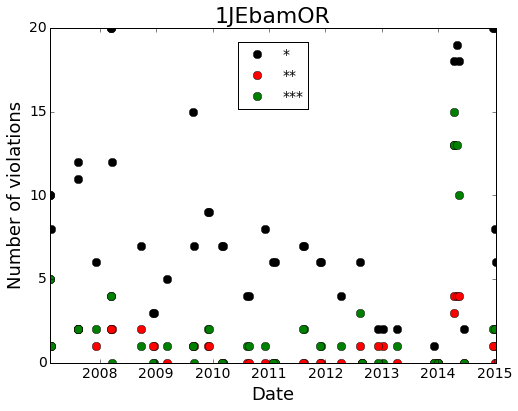

In [22]:
plt.plot(most_inspections.date, most_inspections['*'], 'ko', label='*')
plt.plot(most_inspections.date, most_inspections['**'], 'ro', label='**')
plt.plot(most_inspections.date, most_inspections['***'], 'go', label='***')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper center')
plt.title(num_inspect.index[0])

### Average number of violations for each restaurant (sorted by most violations or worst restaurants)

The size column below gives the number of inspections for each restaurant.

In [23]:
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(10)

weighted_violations         *                       ***      \
                             mean  sum size       mean  sum      mean sum   
restaurant_id                                                               
N6OkRvox                50.000000  100    2  19.000000   38  5.000000  10   
ZBEnAqOY                39.000000  156    4   8.000000   32  5.000000  20   
VpoGe9Er                38.000000   38    1   7.000000    7  5.000000   5   
NbE1xaOJ                28.153846  732   26  11.461538  298  2.807692  73   
WwOapwoB                28.000000   28    1  18.000000   18  2.000000   2   
8x3zj93k                28.000000  308   11   7.181818   79  3.727273  41   
N6OkxvEx                28.000000   84    3   7.666667   23  3.666667  11   
xWoYRrOK                27.272727  300   11   7.090909   78  3.818182  42   
B1oX9NOV                27.222222  245    9   7.555556   68  3.666667  33   
m0oWY1EG                26.833333  322   12   8.833333  106  3.000000  36   

                     **      
                   mean sum  
restaurant_id                
N6OkRvox       2.000000   4  
ZBEnAqOY       2.000000   8  
VpoGe9Er       2.000000   2  
NbE1xaOJ       0.884615  23  
WwOapwoB       0.000000   0  
8x3zj93k       0.727273   8  
N6OkxvEx       0.666667   2  
xWoYRrOK       0.363636   4  
B1oX9NOV       0.444444   4  
m0oWY1EG       1.000000  12

Do the number of violations depend on the size of the restaurant? If so would need to take this into account.

### Average violations model

In [24]:
sb = pd.read_csv('SubmissionFormat.csv')
sb.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,0,0,0
1,29767,2013-12-30,WwOaAnOB,0,0,0
2,29338,2011-04-08,we39kvOk,0,0,0
3,7219,2013-12-30,dj3d5Xo9,0,0,0
4,20979,2008-03-31,XJ3rBW3R,0,0,0


In [25]:
sb_avg_violations = pd.merge(sb, avg_violations, left_on='restaurant_id', right_index=True, how='left').ix[:, [0, 1, 2, 9, 13, 11]]
sb_avg_violations.columns = ['id', 'date', 'restaurant_id', '*', '**', '***']
sb_avg_violations.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,4.466667,0.133333,0.600000
1,29767,2013-12-30,WwOaAnOB,3.764706,0.117647,1.000000
2,29338,2011-04-08,we39kvOk,3.666667,0.166667,1.083333
3,7219,2013-12-30,dj3d5Xo9,2.095238,0.285714,0.238095
4,20979,2008-03-31,XJ3rBW3R,4.818182,1.000000,1.363636


There are a few restaurants in the submission file which are not in the training data:

In [26]:
sb_avg_violations[sb_avg_violations['*'].isnull()]

,id,date,restaurant_id,*,**,***
27,21573,2014-06-27,KAoKJK3g,NaN,NaN,NaN
390,13795,2012-12-30,v5oJ5r3B,NaN,NaN,NaN
468,4154,2012-12-30,Pk3wAqOd,NaN,NaN,NaN
1000,24260,2012-12-30,ZBEndKoY,NaN,NaN,NaN
1160,20517,2012-12-30,8x3zvR3k,NaN,NaN,NaN
1186,13347,2012-12-30,7RO5MrOq,NaN,NaN,NaN
1291,30607,2014-09-26,NbE17moJ,NaN,NaN,NaN
1579,18020,2010-02-08,1JEbg73R,NaN,NaN,NaN
2125,23872,2012-12-30,JGoNX6EL,NaN,NaN,NaN
2506,8806,2012-12-30,njoZZBor,NaN,NaN,NaN


Use the zero model predictions for these cases:

In [27]:
sb_avg_violations['*'].fillna(3, inplace=True)
sb_avg_violations['**'].fillna(0, inplace=True)
sb_avg_violations['***'].fillna(0, inplace=True)
sb_avg_violations[['*', '**', '***']] = sb_avg_violations[['*', '**', '***']].astype(int)

In [28]:
sb_avg_violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6772 entries, 0 to 6771
Data columns (total 6 columns):
id               6772 non-null int64
date             6772 non-null object
restaurant_id    6772 non-null object
*                6772 non-null int64
**               6772 non-null int64
***              6772 non-null int64
dtypes: int64(4), object(2)
memory usage: 317.5+ KB


In [29]:
sb_avg_violations.to_csv('avg_violations_model.csv', index=False, header=True)
sb_avg_violations.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,4,0,0
1,29767,2013-12-30,WwOaAnOB,3,0,1
2,29338,2011-04-08,we39kvOk,3,0,1
3,7219,2013-12-30,dj3d5Xo9,2,0,0
4,20979,2008-03-31,XJ3rBW3R,4,1,1


### How bad are the worst violators?

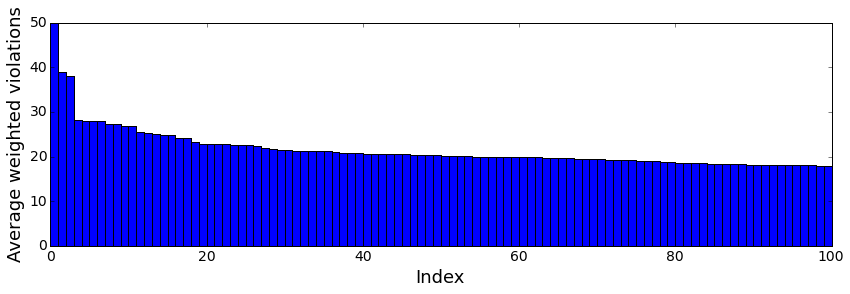

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
worst100 = avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(100)
plt.bar(range(100), worst100[('weighted_violations', 'mean')], width=1)
plt.xlabel('Index')
plt.ylabel('Average weighted violations')

Below are the restaurants with the least weighted_violations. Note that many have few inspections.

In [31]:
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).tail()

weighted_violations        *           ***       **    
                             mean sum size mean sum mean sum mean sum
restaurant_id                                                        
B1oXYqOV                      0.0   0    1  0.0   0  0.0   0  0.0   0
we39RZok                      0.0   0    1  0.0   0  0.0   0  0.0   0
1JEbYwOR                      0.0   0    1  0.0   0  0.0   0  0.0   0
B1oX5DOV                      0.0   0    1  0.0   0  0.0   0  0.0   0
v5oJR8oB                      0.0   0    1  0.0   0  0.0   0  0.0   0

### Time period over which inspections have taken place by restaurant

The column inspect_window is the number of years between the first and last inspection:

In [32]:
dt = df.groupby('restaurant_id').agg({'date': [np.min, np.max]})
dt['inspect_window'] = (dt[('date', 'amax')] - dt[('date', 'amin')]) / np.timedelta64(1, 'Y')
dt.describe()

,inspect_window
,
count,1851.000000
mean,5.500560
std,2.050375
min,0.000000
25%,4.606529
50%,6.130174
75%,7.055586
max,8.421802


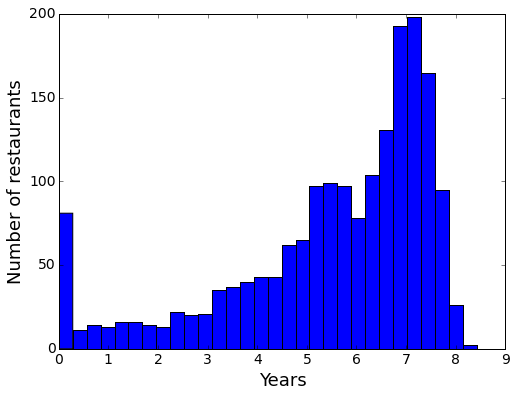

In [33]:
plt.hist(dt[('inspect_window')], bins=30)
plt.xlabel('Years')
plt.ylabel('Number of restaurants')

### How many times is a restaurant inspected in a year?

In [34]:
dates_inspections = pd.merge(dt, pd.DataFrame(df.groupby('restaurant_id').size()), left_index=True, right_index=True, how='inner')
dates_inspections.columns = ['min_date', 'max_date', 'inspect_window', 'number_of_inspections']
dates_inspections.describe()

,inspect_window,number_of_inspections
count,1851.000000,1851.000000
mean,5.500560,14.634252
std,2.050375,7.876801
min,0.000000,1.000000
25%,4.606529,9.000000
50%,6.130174,14.000000
75%,7.055586,20.000000
max,8.421802,45.000000


Next we filter out cases with only 1 inspection (to remove inf) and compute a rate column:

In [35]:
dates_inspections = dates_inspections[dates_inspections['number_of_inspections'] > 1]
dates_inspections['inspection_rate'] = dates_inspections['number_of_inspections'] / dates_inspections['inspect_window']
dates_inspections.describe()

,inspect_window,number_of_inspections,inspection_rate
count,1784.000000,1784.000000,1784.000000
mean,5.707140,15.146300,3.287859
std,1.783921,7.558292,11.462731
min,0.005476,2.000000,0.343758
25%,4.844042,9.000000,1.988432
50%,6.224632,15.000000,2.638288
75%,7.074752,20.000000,3.330985
max,8.421802,45.000000,365.242500


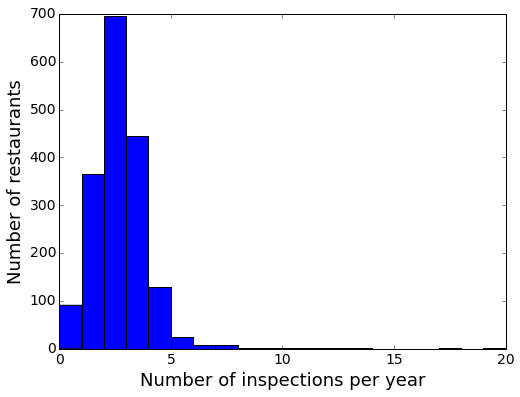

In [36]:
plt.hist(dates_inspections['inspection_rate'], bins=20, range=(0, 20))
plt.ylabel('Number of restaurants')
plt.xlabel('Number of inspections per year')
plt.ylabel('Number of restaurants')